# Learning Pyspark for Big Data: Titanic Dataset

In [1]:
from pyspark.sql import SparkSession

# Initialize a SparkSession
spark = SparkSession.builder.master("local[*]").appName('Titanic Analysis').getOrCreate()


# Set the configuration to increase the maxToStringFields limit
spark.conf.set("spark.sql.debug.maxToStringFields", 100)

23/10/26 00:34:11 WARN Utils: Your hostname, kayc resolves to a loopback address: 127.0.1.1; using 192.168.228.91 instead (on interface eth0)
23/10/26 00:34:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/26 00:34:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
#Load data
titanic_data = spark.read.csv('/home/kaycodes/datasets/titanic_dataset.csv', header=True, inferSchema=True)

In [3]:
#Show data
titanic_data.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
|          6|       0|     3|    Moran, Mr. James|  male|NULL|    0|    0|      

In [4]:
# Print the Schema of the DataFrame
titanic_data.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [5]:
# Basic Statistics for numerical columns
titanic_data.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                NULL|  NULL| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

## Data Cleaning

In [6]:
from pyspark.sql.functions import count

#Total number of rows in the dataset
titanic_data.count()

891

In [7]:
# Count missing values per column
for col in titanic_data.columns:
    missing_count = titanic_data.filter(titanic_data[col].isNull()).count()
    print(f'Missing values in {col}: {missing_count}')

Missing values in PassengerId: 0
Missing values in Survived: 0
Missing values in Pclass: 0
Missing values in Name: 0
Missing values in Sex: 0
Missing values in Age: 177
Missing values in SibSp: 0
Missing values in Parch: 0
Missing values in Ticket: 0
Missing values in Fare: 0
Missing values in Cabin: 687
Missing values in Embarked: 2


Age has 177 missing values and cabin has 687 null entries, while embarked has 2 only. To handle the missing values, we input the age using the mean. For cabin, the column can be droped for this case. For embarked, we handle the two missing values through mode imputation.

In [8]:
#Impute missing age values with mean
mean_age=titanic_data.agg({'Age':'mean'}).collect()[0][0]
titanic_data = titanic_data.na.fill({'Age': mean_age})

In [9]:
#drop cabin
titanic_data=titanic_data.drop('Cabin')

In [10]:
# Embarked
# impute with mode
mode_embarked = titanic_data.groupBy('Embarked').count().orderBy('count', ascending=False).first()[0]
titanic_data = titanic_data.na.fill({'Embarked': mode_embarked})

In [11]:
titanic_data.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+
only showing top 5 

In [12]:
# Check datatypes
titanic_data.dtypes

[('PassengerId', 'int'),
 ('Survived', 'int'),
 ('Pclass', 'int'),
 ('Name', 'string'),
 ('Sex', 'string'),
 ('Age', 'double'),
 ('SibSp', 'int'),
 ('Parch', 'int'),
 ('Ticket', 'string'),
 ('Fare', 'double'),
 ('Embarked', 'string')]

In [13]:
#Create a new feature :Familysize, using
#SibSp: The number of siblings or spouses the passenger had aboard the Titanic.
#Parch: The number of parents or children the passenger had aboard the Titanic.
#Each passenger counts as one individual, so we add 1 to account for the passenger themself.

# Create a FamilySize feature
titanic_data = titanic_data.withColumn("FamilySize", titanic_data["SibSp"] + titanic_data["Parch"] + 1)

titanic_data.show()

+-----------+--------+------+--------------------+------+-----------------+-----+-----+----------------+-------+--------+----------+
|PassengerId|Survived|Pclass|                Name|   Sex|              Age|SibSp|Parch|          Ticket|   Fare|Embarked|FamilySize|
+-----------+--------+------+--------------------+------+-----------------+-----+-----+----------------+-------+--------+----------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|             22.0|    1|    0|       A/5 21171|   7.25|       S|         2|
|          2|       1|     1|Cumings, Mrs. Joh...|female|             38.0|    1|    0|        PC 17599|71.2833|       C|         2|
|          3|       1|     3|Heikkinen, Miss. ...|female|             26.0|    0|    0|STON/O2. 3101282|  7.925|       S|         1|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|             35.0|    1|    0|          113803|   53.1|       S|         2|
|          5|       0|     3|Allen, Mr. Willia...|  male|            

## Data Exploration

In [14]:
#Descriptive statistics
titanic_data.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+--------+-----------------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Embarked|       FamilySize|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+--------+-----------------+
|  count|              891|                891|               891|                 891|   891|               891|               891|                891|               891|              891|     891|              891|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                NULL|  NULL|29.699117647058763|0.5230078563411896|

In [15]:
#Correlation Analysis
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Select only the numerical columns
numerical_cols = [col_name for col_name, dtype in titanic_data.dtypes if dtype in ['int', 'double']]


# Assemble the features into a single vector
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
assembled_data = assembler.transform(titanic_data)

# Compute correlations
matrix = Correlation.corr(assembled_data, "features").head()

# The correlation matrix
print("Pearson correlation matrix:\n" + str(matrix[0]))


Pearson correlation matrix:
DenseMatrix([[ 1.        , -0.00500666, -0.03514399,  0.03320655, -0.05752683,
              -0.00165201,  0.01265822, -0.04014293],
             [-0.00500666,  1.        , -0.33848104, -0.06980852, -0.0353225 ,
               0.08162941,  0.25730652,  0.01663899],
             [-0.03514399, -0.33848104,  1.        , -0.33133877,  0.08308136,
               0.01844267, -0.54949962,  0.06599691],
             [ 0.03320655, -0.06980852, -0.33133877,  1.        , -0.23262459,
              -0.17919092,  0.09156609, -0.24851173],
             [-0.05752683, -0.0353225 ,  0.08308136, -0.23262459,  1.        ,
               0.4148377 ,  0.15965104,  0.89071167],
             [-0.00165201,  0.08162941,  0.01844267, -0.17919092,  0.4148377 ,
               1.        ,  0.21622494,  0.78311078],
             [ 0.01265822,  0.25730652, -0.54949962,  0.09156609,  0.15965104,
               0.21622494,  1.        ,  0.21713841],
             [-0.04014293,  0.01663899,  

23/10/26 00:34:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


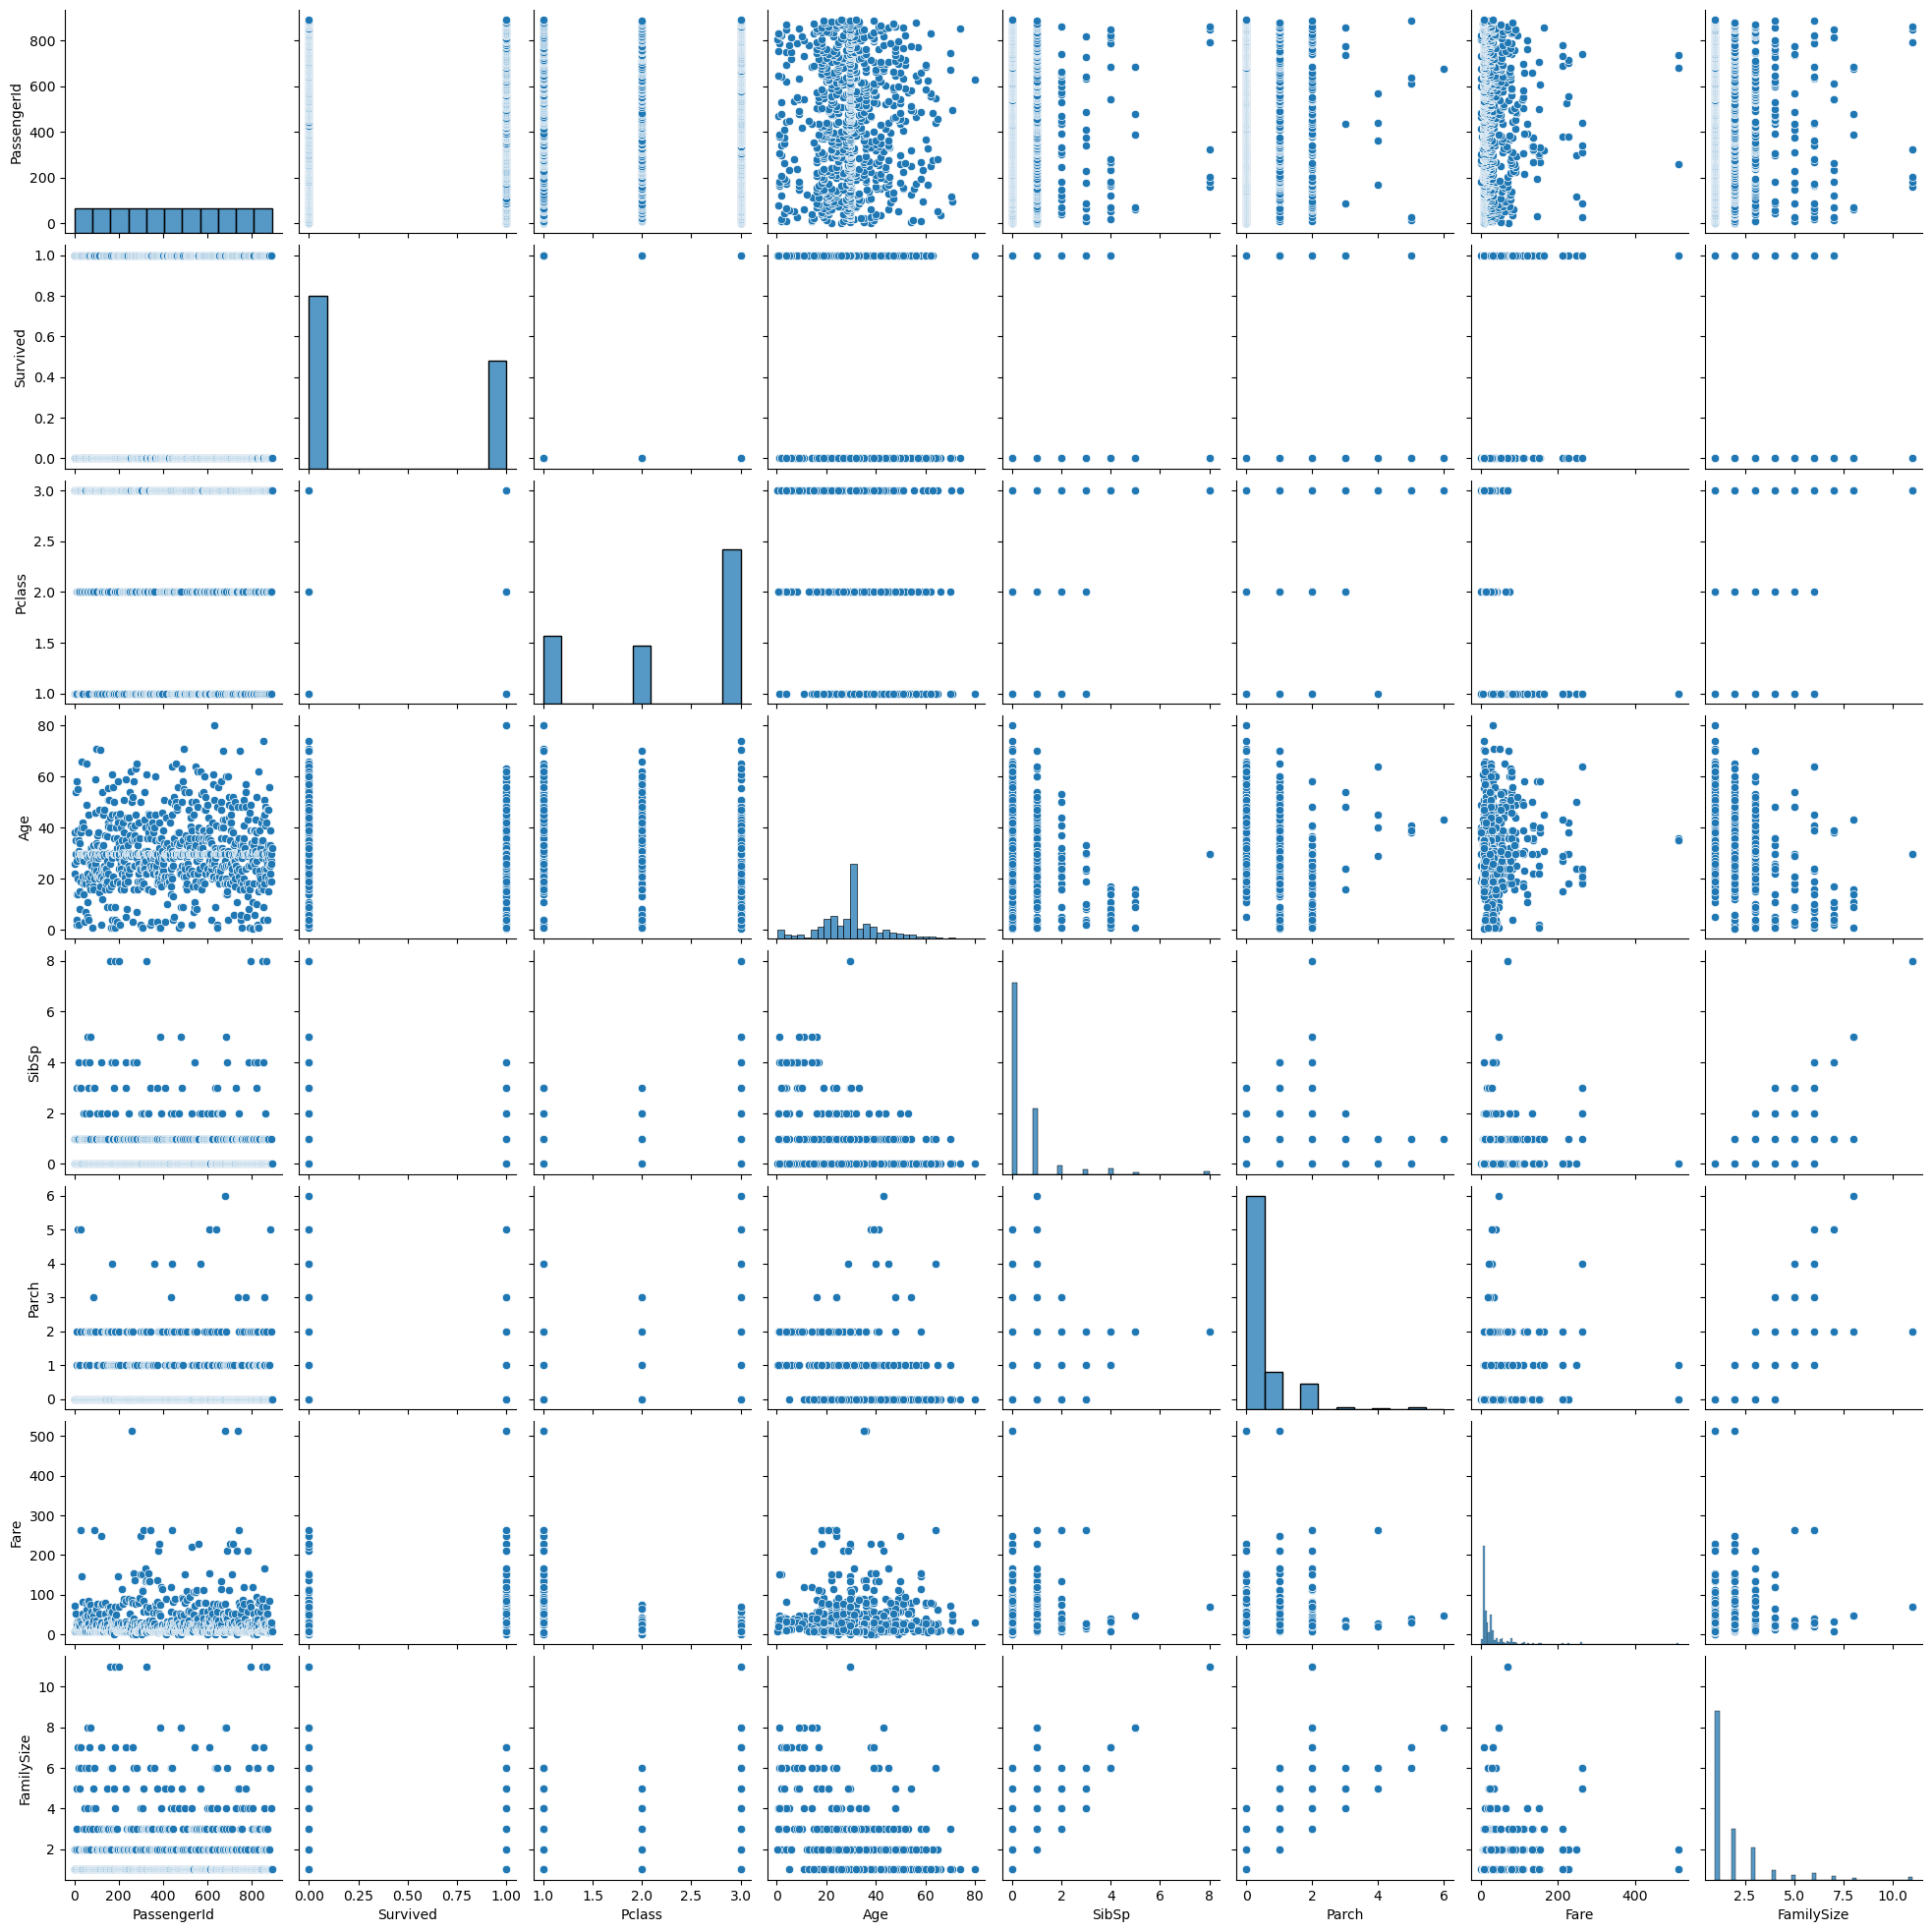

In [16]:
# Data Exploration
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pandas_df =titanic_data.toPandas()
sns.pairplot(pandas_df)
plt.show()

In [17]:
#More visuals

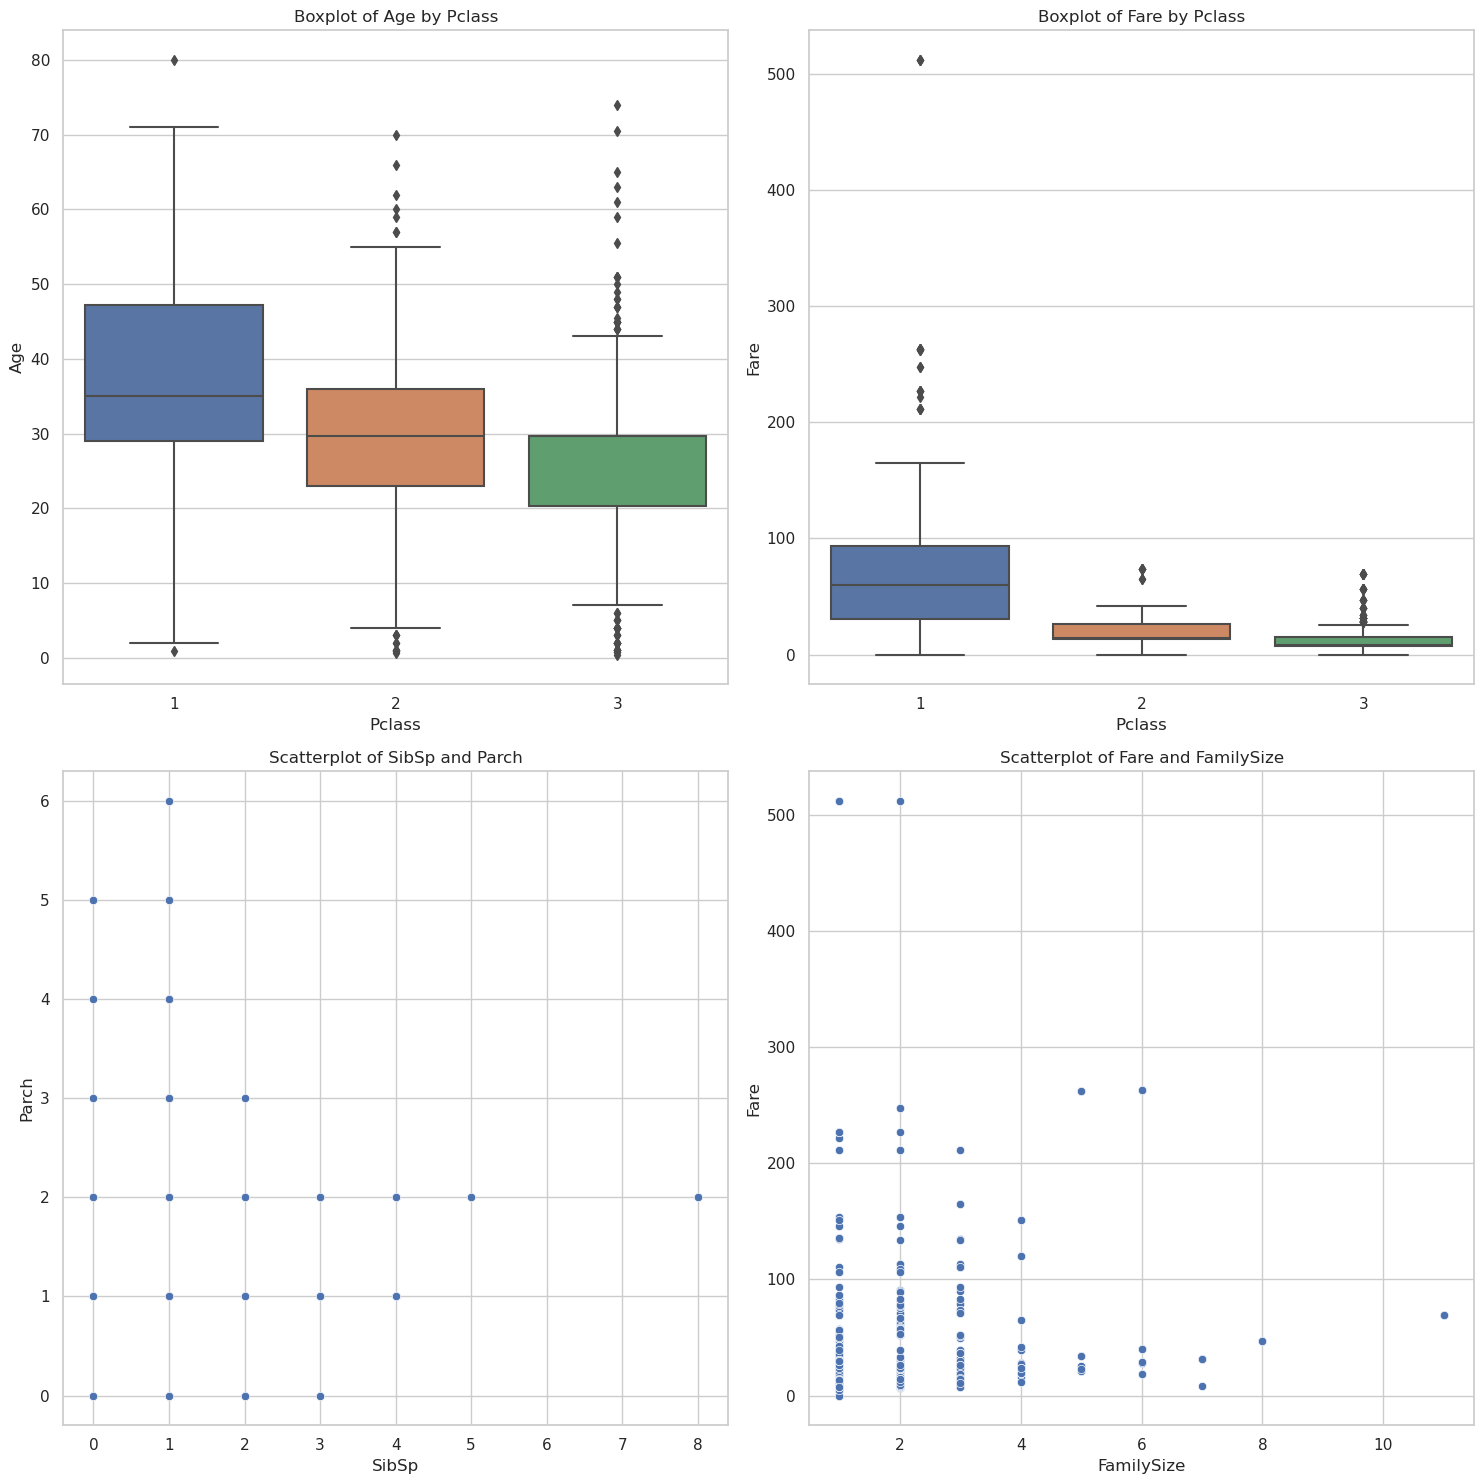

In [18]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")
# Create a figure object
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
# Plotting the relationship between Pclass and Age
sns.boxplot(x='Pclass', y='Age', data=pandas_df, ax=axs[0, 0])
axs[0, 0].set_title('Boxplot of Age by Pclass')

# Plotting the relationship between Pclass and Fare
sns.boxplot(x='Pclass', y='Fare', data=pandas_df, ax=axs[0, 1])
axs[0, 1].set_title('Boxplot of Fare by Pclass')

# Plotting the relationship between SibSp and Parch
sns.scatterplot(x='SibSp', y='Parch', data=pandas_df, ax=axs[1, 0])
axs[1, 0].set_title('Scatterplot of SibSp and Parch')

# Plotting the relationship between Fare and FamilySize
pandas_df['FamilySize'] = pandas_df['SibSp'] + pandas_df['Parch'] + 1  # Recreate FamilySize column
sns.scatterplot(x='FamilySize', y='Fare', data=pandas_df, ax=axs[1, 1])
axs[1, 1].set_title('Scatterplot of Fare and FamilySize')

# Show the plots
plt.tight_layout()
plt.show()

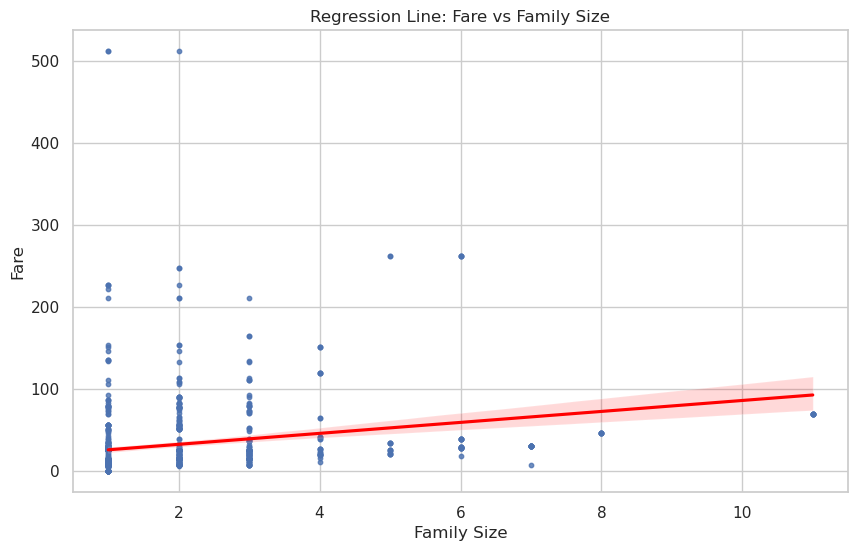

In [19]:
# Create the FamilySize column in the Pandas DataFrame
pandas_df['FamilySize'] = pandas_df['SibSp'] + pandas_df['Parch'] + 1

# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create the regression plot
plt.figure(figsize=(10, 6))
sns.regplot(x='FamilySize', y='Fare', data=pandas_df, scatter_kws={'s':10}, line_kws={'color':'red'})
plt.title('Regression Line: Fare vs Family Size')
plt.xlabel('Family Size')
plt.ylabel('Fare')
plt.show()

## Machine Learning

### Step 1: Data Preparation
Before modeling, ensure that your data is well-prepared, with features assembled into a single vector and the data split into training and testing sets.

In [20]:
from pyspark.ml.feature import VectorAssembler

# Assemble features
feature_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']  # Add more features as needed
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(titanic_data)

# Split data
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=1234)


### Step 2: Build and Train Models
Create and train machine learning models using the training data. We'll start with Logistic Regression as an example:

In [21]:
from pyspark.ml.classification import LogisticRegression

# Logistic Regression
lr = LogisticRegression(labelCol="Survived", featuresCol="features")
lr_model = lr.fit(train_data)


### Step 3: Evaluate Models
Evaluate the performance of the models using the testing data:

In [22]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate Logistic Regression
test_results = lr_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="Survived")
auc = evaluator.evaluate(test_results)
print(f"AUC: {auc}")


AUC: 0.7292018170019471


### Step 4: Hyperparameter Tuning
Tune the hyperparameters of the models to improve performance:

In [25]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 1.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cv_model = cv.fit(train_data)

# Get the best model
lr_best_model = cv_model.bestModel


LogisticRegressionModel: uid=LogisticRegression_9daf94c886b8, numClasses=2, numFeatures=5

### Step 5: Evaluate the Tuned Model


In [26]:
# Evaluate the best model
tuned_test_results = lr_best_model.transform(test_data)
tuned_auc = evaluator.evaluate(tuned_test_results)
print(f"Tuned AUC: {tuned_auc}")


Tuned AUC: 0.7340038935756


### Step 6: Explore Other Models


In [27]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier

# Random Forest
rf = RandomForestClassifier(labelCol="Survived", featuresCol="features")
rf_model = rf.fit(train_data)
rf_test_results = rf_model.transform(test_data)
rf_auc = evaluator.evaluate(rf_test_results)
print(f"Random Forest AUC: {rf_auc}")

# Gradient Boosted Trees
gbt = GBTClassifier(labelCol="Survived", featuresCol="features")
gbt_model = gbt.fit(train_data)
gbt_test_results = gbt_model.transform(test_data)
gbt_auc = evaluator.evaluate(gbt_test_results)
print(f"Gradient Boosted Trees AUC: {gbt_auc}")


Random Forest AUC: 0.7495133030499677
Gradient Boosted Trees AUC: 0.7632706035042178
